In [1]:
import warnings
import os

from sympy import Symbol
from numpy.testing import assert_allclose
import numpy as np
from pycalphad import Database, Model, calculate, equilibrium, EquilibriumError, ConditionError
from pycalphad.codegen.callables import build_callables
from pycalphad.core.solver import SolverBase, Solver
from pycalphad.core.utils import get_state_variables
import pycalphad.variables as v
from pycalphad.tests.datasets import *

warnings.simplefilter("always", UserWarning) # so we can test warnings


In [2]:
import pycalphad
pycalphad

<module 'pycalphad' from '/Users/sunhui/Desktop/new-charge/pycalphad/pycalphad/__init__.py'>

In [3]:
AL2O3_ND2O3_ZRO2_DBF = Database(AL2O3_ND2O3_ZRO2_TDB)
alfeo=Database("Al-Fe-O_Lindwall_etal.TDB")

/Users/sunhui/Desktop/new-charge/pycalphad/pycalphad/io/tdb.py:974: UserWarning: The type definition character `W` was defined in the following phases: ['BCC_B2'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


In [8]:
def _sample_phase_constitution(model, sampler, fixed_grid, pdens):
    """
    Sample the internal degrees of freedom of a phase.

    Parameters
    ----------
    model : Model
        Instance of a pycalphad Model
    sampler : Callable
        Callable returning an ArrayLike of points
    fixed_grid : bool
        If True, sample pdens points between each pair of endmembers
    pdens : int
        Number of points to sample in each sampled dimension

    Returns
    -------
    ndarray of points
    """
    # Eliminate pure vacancy endmembers from the calculation
    import itertools
    ALLOWED_CHARGE=1E-10
    vacancy_indices = []
    for sublattice in model.constituents:
        subl_va_indices = [idx for idx, spec in enumerate(sorted(set(sublattice))) if spec.number_of_atoms == 0]
        vacancy_indices.append(subl_va_indices)
    if len(vacancy_indices) != len(model.constituents):
        vacancy_indices = None
    sublattice_dof = [len(subl) for subl in model.constituents]
    # Add all endmembers to guarantee their presence
    points = endmember_matrix(sublattice_dof, vacancy_indices=vacancy_indices)
    site_ratios = mod.site_ratios
    print('site',site_ratios)
    species_charge=[]
    for sublattice in range(len(model.constituents)):
        print(sublattice)
        for species in sorted(model.constituents[sublattice]):
            species_charge.append(species.charge*site_ratios[sublattice])
    species_charge=np.array(species_charge)
    #species_charge=species_charge.reshape(species_charge.shape[0],1)
    print('points',points)
    print('charge',species_charge)
    Q=np.sum(points*species_charge,axis=1)
    print(Q)
    Q_p=[]
    Q_0=[]
    Q_n=[]
    for q in range(len(Q)):
        if Q[q]>ALLOWED_CHARGE:
            Q_p.append(q)
        elif np.abs(Q[q])<ALLOWED_CHARGE:
            Q_0.append(points[q,:])
        else:
            Q_n.append(q)
    print('Q',Q_p,Q_n,Q_0)
    all_comb=itertools.product(Q_p,Q_n)
    Q_value=np.abs(Q)
    update_points=np.asarray(Q_0)
    for comb in all_comb:
        Q_sum=Q_value[comb[1]]+Q_value[comb[0]]
        charge_endmember=(points[comb[0],:]*Q_value[comb[1]]+points[comb[1],:]*Q_value[comb[0]])/Q_sum
        update_points=np.insert(update_points,0,values=charge_endmember,axis=0)
    if fixed_grid is True:
        # Sample along the edges of the endmembers
        # These constitution space edges are often the equilibrium points!
        em_pairs = list(itertools.combinations(update_points, 2))
        lingrid = np.linspace(0, 1, pdens)
        extra_points = [first_em * lingrid[np.newaxis].T +
                        second_em * lingrid[::-1][np.newaxis].T
                        for first_em, second_em in em_pairs]
        points = np.concatenate(list(itertools.chain([update_points], extra_points)))
    # Sample composition space for more points
    if sum(sublattice_dof) > len(sublattice_dof):
        if len(Q_p)>0:
            sample=sampler([len(update_points)], pdof=pdens)
            points_new=sample.dot(update_points)
            points = np.concatenate((points,points_new))
        else:
            points = np.concatenate((points, sampler(sublattice_dof, pdof=pdens)))
        #Q=np.sum(points_new*species_charge,axis=1)

    # Filter out nan's that may have slipped in if we sampled too high a vacancy concentration
    # Issues with this appear to be platform-dependent
    points = points[~np.isnan(points).any(axis=-1)]
    # Ensure that points has the correct dimensions and dtype
    points = np.atleast_2d(np.asarray(points, dtype=np.float_))
    return points

In [9]:
from pycalphad.core.utils import endmember_matrix, extract_parameters, \
    get_pure_elements, filter_phases, instantiate_models, point_sample, \
    unpack_components, unpack_condition, unpack_kwarg
comps = ['AL', 'FE', 'O', 'VA']
phases = ['SPINEL_B']
model = None
parameters = dict()
models = instantiate_models(alfeo, comps, phases, model=model, parameters=parameters)
mod = models[phases[0]]
a=_sample_phase_constitution(mod,point_sample,True, 2000)
print('re',a)

site (1.0, 2.0, 2.0, 4.0)
0
1
2
3
points [[1.e+00 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e+00]
 [1.e+00 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e+00]
 [1.e+00 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e+00 1.e-14 1.e+00]
 [1.e+00 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e+00 1.e+00]
 [1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e+00 1.e-14 1.e+00]
 [1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e+00 1.e+00]
 [1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e+00 1.e-14 1.e+00]
 [1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e+00 1.e+00]
 [1.e-14 1.e+00 1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e+00]
 [1.e-14 1.e+00 1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e+00]
 [1.e-14 1.e+00 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e+00 1.e-14 1.e+00]
 [1.e-14 1.e+00 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e+00 1.e+00]
 [1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14 1.e+00 1.e-14 1.e+00]
 [1.e-14 1

In [2]:
def test_charge_balance_constraint():
    """Phases with charged species are correctly calculated and charged balanced in equilibrium"""
    AL2O3_ND2O3_ZRO2_DBF = Database(AL2O3_ND2O3_ZRO2_TDB)
    alfeo=Database("Al-Fe-O_Lindwall_etal.TDB")
    comps = ['AL', 'FE', 'O', 'VA']
    #phases = list(alfeo.phases.keys())
    #print(phases)
    phases = ['GAS']
    
    conds = {v.P: 101325, v.N: 1, v.T: 500, v.X('FE'): 0.2, v.X('O'): 0.6}
    # Higher point density is required for convergence. Lower point densities
    # Can result in either no phases, or only FLUO phase (incorrect)
    res = equilibrium(alfeo, comps, phases, conds, calc_opts={'pdens':2000}, verbose=True)
    #result = calculate(alfeo, comps, phases, P=101325, T=500, output='GM')
    # Values below checked with Thermo-Calc
    #print('result',res.GM.values.flat[0])
    assert np.allclose(res.NP.values.squeeze()[:2], [0.47826862, 0.52173138])
    assert np.allclose(res.GM.values.flat[0], -257462.33)
    # site fractions of ND2O3_A
    Y_ND2O3_A = res.Y.values.squeeze()[0, :5]
    Y_PYRO = res.Y.values.squeeze()[1, :]
    SPEC_CHG_ND2O3_A = np.array([3, 4, -2, -2, 0])  # (ND+3,ZR+4):(O-2):(O-2,VA)
    SITE_RATIO_ND2O3_A = np.array([2, 2, 3, 1, 1])  # 2:3:1
    SPEC_CHG_PYRO = np.array([3, 4, 3, 4, -2, 0, -2, -2, 0])  # (ND+3,ZR+4):(ND+3,ZR+4):(O-2,VA):(O-2):(O-2,VA)
    SITE_RATIO_PYRO = np.array([2, 2, 2, 2, 6, 6, 1, 1, 1])  # 2:2:6:1:1
    CHG_ND2O3_A = np.dot(Y_ND2O3_A*SPEC_CHG_ND2O3_A, SITE_RATIO_ND2O3_A)
    CHG_PYRO = np.dot(Y_PYRO*SPEC_CHG_PYRO, SITE_RATIO_PYRO)
    print('CHARGE ND2O3_A', CHG_ND2O3_A)
    print('CHARGE PYRO', CHG_PYRO)
    #assert np.isclose(CHG_ND2O3_A, 0)
    #assert np.isclose(CHG_PYRO, 0)
    print(Y_ND2O3_A)
    assert np.allclose(Y_ND2O3_A, [9.79497936e-01, 2.05020639e-02, 1.00000000e+00, 2.05020639e-02, 9.79497936e-01], rtol=5e-4)
    assert np.allclose(Y_PYRO, [9.99970071e-01, 2.99288042e-05, 3.83395063e-02, 9.61660494e-01, 9.93381787e-01, 6.61821340e-03, 1.00000000e+00, 1.39970285e-03, 9.98600297e-01], rtol=5e-4)


In [3]:
a=test_charge_balance_constraint()

/Users/sunhui/Desktop/new-charge/pycalphad/pycalphad/io/tdb.py:974: UserWarning: The type definition character `W` was defined in the following phases: ['BCC_B2'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


Components: AL AL+3 AL1O1 AL1O2 AL2 AL2FE1O4 AL2O AL2O1 AL2O2 AL2O3 ALO ALO2 ALO3/2 FE FE+2 FE+3 FE+4 FE1O1 FE1O2 FE2 FE2O3 FEO FEO3/2 O O-2 O2 O3 VA
Phases: GAS 
[done]
Q [] [] [array([1.e+00, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14]), array([1.e-14, 1.e+00, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14]), array([1.e-14, 1.e-14, 1.e+00, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14]), array([1.e-14, 1.e-14, 1.e-14, 1.e+00, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14]), array([1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e+00, 1.e-14, 1.e-14, 1.e-14,
       1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14, 1.e-14,
       1.e-14]), array([1.e-14, 1.e-14, 1.e

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge Composi

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge Compositi

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge Composi

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge Com

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge Compo

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge Com

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge Compo

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge Compo

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge Compo

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, 

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge Composi

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge Com

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge Composi

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, 

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge Compo

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge Com

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge Com

k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge Composi

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge Compo

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, 

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0

k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) AL+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+2 2
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+3 3
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) FE+4 4
k_charge CompositionSet(GAS, [0.20018007 0.19987995 0.59993998], NP=0.3333663499134687, GM=-75282.48842986801) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) AL+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0

k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+2 2
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+3 3
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) FE+4 4
k_charge CompositionSet(GAS, [0.19990995 0.20006003 0.60003002], NP=0.6666326500875314, GM=-75210.07842849342) O-2 -2
charge_factor True
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) AL+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+2 2
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+3 3
k_charge CompositionSet(GAS, [0.1701951  0.19150408 0.63830082], NP=9.99999000001107e-07, GM=-73255.30384211826) FE+4 4
k_charge CompositionSet(GAS, 

AssertionError: 

In [3]:
alfeo=Database("Al-Fe-O_Lindwall_etal.TDB")
comps = ['FE', 'O', 'VA']
phases = ['GAS']
print(phases)
#phases = ['HALITE']
legend_handles, color_dict = phase_legend(phases)

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
result = calculate(alfeo, ['FE', 'O', 'VA'], phases, P=101325, T=300, output='GM')
ax.scatter(result.X.sel(component='FE'), result.GM, marker='.', s=5)  
ax.set_xlabel('X(FE)')
ax.set_ylabel('GM')
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()
#conds = {v.P: 101325, v.N: 1, v.T: 300, v.X('FE'): 0.1}
# Higher point density is required for convergence. Lower point densities
# Can result in either no phases, or only FLUO phase (incorrect)
#res = equilibrium(alfeo, comps, phases, conds)

/Users/sunhui/Desktop/new-charge/pycalphad/pycalphad/io/tdb.py:974: UserWarning: The type definition character `W` was defined in the following phases: ['BCC_B2'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


['GAS']


NameError: name 'phase_legend' is not defined

In [63]:
res.GM.values

array([[[[nan]]]])

[1.0e-10 1.0e-02 2.0e-02 3.0e-02 4.0e-02 5.0e-02 6.0e-02 7.0e-02 8.0e-02
 9.0e-02 1.0e-01 1.1e-01 1.2e-01 1.3e-01 1.4e-01 1.5e-01 1.6e-01 1.7e-01
 1.8e-01 1.9e-01 2.0e-01 2.1e-01 2.2e-01 2.3e-01 2.4e-01 2.5e-01 2.6e-01
 2.7e-01 2.8e-01 2.9e-01 3.0e-01 3.1e-01 3.2e-01 3.3e-01 3.4e-01 3.5e-01
 3.6e-01 3.7e-01 3.8e-01 3.9e-01 4.0e-01 4.1e-01 4.2e-01]
[0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]
[0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]
[]


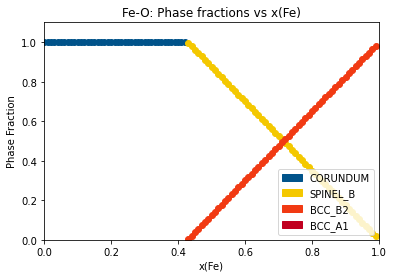

In [57]:
from pycalphad.plot.utils import phase_legend
import matplotlib.pyplot as plt
phase_handles, phasemap = phase_legend(phases)

plt.gca().set_title('Fe-O: Phase fractions vs x(Fe)')
plt.gca().set_xlabel('x(Fe)')
plt.gca().set_ylabel('Phase Fraction')
plt.gca().set_ylim((0,1.1))
plt.gca().set_xlim((0,1))

for name in phases:
    phase_indices = np.nonzero(res.Phase.values == name)
    print(np.take(res['X_FE'].values, phase_indices[3]))
    plt.scatter(np.take(res['X_FE'].values, phase_indices[3]), res.NP.values[phase_indices], color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='lower right')

In [9]:
import warnings
import os
import pytest
from sympy import Symbol
from numpy.testing import assert_allclose
import numpy as np
from pycalphad import Database, Model, calculate, equilibrium, EquilibriumError, ConditionError
from pycalphad.codegen.callables import build_callables, build_phase_records
from pycalphad.core.solver import SolverBase, Solver
from pycalphad.core.utils import get_state_variables, instantiate_models
import pycalphad.variables as v
from pycalphad.tests.datasets import *
ROSE_DBF = Database(ROSE_TDB)
ALFE_DBF = Database(ALFE_TDB)
ALNIFCC4SL_DBF = Database(ALNIFCC4SL_TDB)
ALCOCRNI_DBF = Database(ALCOCRNI_TDB)
ISSUE43_DBF = Database(ISSUE43_TDB)
TOUGH_CHEMPOT_DBF = Database(ALNI_TOUGH_CHEMPOT_TDB)
NI_AL_DUPIN_2001_DBF = Database(NI_AL_DUPIN_2001_TDB)
CUO_DBF = Database(CUO_TDB)
PBSN_DBF = Database(PBSN_TDB)
AL_PARAMETER_DBF = Database(AL_PARAMETER_TDB)
CUMG_PARAMETERS_DBF = Database(CUMG_PARAMETERS_TDB)


@pytest.mark.solver
def test_rose_nine():
    "Nine-component rose diagram point equilibrium calculation."
    my_phases_rose = ['TEST']
    comps = ['H', 'HE', 'LI', 'BE', 'B', 'C', 'N', 'O', 'F']
    conds = dict({v.T: 1000, v.P: 101325})
    for comp in comps[:-1]:
        conds[v.X(comp)] = 1.0/float(len(comps))
    eqx = equilibrium(ROSE_DBF, comps, my_phases_rose, conds, verbose=True)
    assert_allclose(eqx.GM.values.flat[0], -5.8351e3, atol=0.1)


@pytest.mark.solver
def test_eq_binary():
    "Binary phase diagram point equilibrium calculation with magnetism."
    my_phases = ['LIQUID', 'FCC_A1', 'HCP_A3', 'AL5FE2',
                 'AL2FE', 'AL13FE4', 'AL5FE4']
    comps = ['AL', 'FE', 'VA']
    conds = {v.T: 1400, v.P: 101325, v.X('AL'): 0.55}
    eqx = equilibrium(ALFE_DBF, comps, my_phases, conds, verbose=True)
    assert_allclose(eqx.GM.values.flat[0], -9.608807e4)
def test_eq_single_phase():
    "Equilibrium energy should be the same as for a single phase with no miscibility gaps."
    res = calculate(ALFE_DBF, ['AL', 'FE'], 'LIQUID', T=[1400, 2500], P=101325,
                    points={'LIQUID': [[0.1, 0.9], [0.2, 0.8], [0.3, 0.7],
                                       [0.7, 0.3], [0.8, 0.2]]})
    eq = equilibrium(ALFE_DBF, ['AL', 'FE'], 'LIQUID',
                     {v.T: [1400, 2500], v.P: 101325,
                      v.X('AL'): [0.1, 0.2, 0.3, 0.7, 0.8]}, verbose=True)
    assert_allclose(np.squeeze(eq.GM), np.squeeze(res.GM), atol=0.1)


/Users/sunhui/Desktop/new-charge/pycalphad/pycalphad/io/tdb.py:974: UserWarning: The type definition character `'` was defined in the following phases: ['FCC_A1'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "
/Users/sunhui/Desktop/new-charge/pycalphad/pycalphad/io/tdb.py:974: UserWarning: The type definition character `%` was defined in the following phases: ['FCC_A1'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


In [10]:
test_eq_binary()

Components: AL FE VA
Phases: AL13FE4 
AL2FE 
AL5FE2 
AL5FE4 
FCC_A1 
HCP_A3 
LIQUID 
[done]
sample <function point_sample at 0x15fdd7940>
Q [] [] [array([1.e+00, 1.e+00, 1.e+00, 1.e-14]), array([1.e+00, 1.e+00, 1.e-14, 1.e+00])]
here
sample <function point_sample at 0x15fdd7940>
Q [] [] [array([1., 1.])]
here
sample <function point_sample at 0x15fdd7940>
Q [] [] [array([1., 1.])]
here
sample <function point_sample at 0x15fdd7940>
Q [] [] [array([1.e+00, 1.e-14]), array([1.e-14, 1.e+00])]
here
sample <function point_sample at 0x15fdd7940>
Q [] [] [array([1.e+00, 1.e-14, 1.e+00]), array([1.e-14, 1.e+00, 1.e+00])]
here
sample <function point_sample at 0x15fdd7940>
Q [] [] [array([1.e+00, 1.e-14, 1.e+00]), array([1.e-14, 1.e+00, 1.e+00])]
here
sample <function point_sample at 0x15fdd7940>
Q [] [] [array([1.e+00, 1.e-14]), array([1.e-14, 1.e+00])]
here
compset_phases ['N', 'P', 'T', 'X_AL', 'vertex'] [[[[['' '' '']]]]]
Adding metastable CompositionSet(LIQUID, [0.55102041 0.44897959], NP=0.0

In [6]:
a=np.array([-1,2,-2,3])

In [1]:
! pytest test_equilibrium.py

============================= test session starts ==============================
platform darwin -- Python 3.9.7, pytest-6.2.5, py-1.10.0, pluggy-1.0.0
rootdir: /Users/sunhui/Desktop/new-charge/pycalphad, configfile: pyproject.toml
plugins: cov-2.12.1
collected 50 items                                                             

test_equilibrium.py ...........F......FF..F...............s....F.FFFF.   [100%]

=================================== FAILURES ===================================
_______________________ test_eq_illcond_magnetic_hessian _______________________

    @pytest.mark.solver
    def test_eq_illcond_magnetic_hessian():
        """
        Check equilibrium of a system with an ill-conditioned Hessian due to magnetism (Tc->0).
        This is difficult to reproduce so we only include some known examples here.
        """
        # This set of conditions is known to trigger the issue
        eq = equilibrium(ALFE_DBF, ['AL', 'FE', 'VA'], ['FCC_A1', 'AL13FE4'],
          

 CompositionSet(AL13FE4, [0.75751514 0.24248486], NP=1e-06, GM=-35805.854396523304)]
site [1.00000000e+00 1.00000000e+05 3.00000000e+02 9.99999961e-01
 3.93890037e-08 1.00000000e+00]
len 6 4
compset [CompositionSet(FCC_A1, [0.8 0.2], NP=1.0, GM=-17803.320902447096)
 CompositionSet(AL13FE4, [0.75751514 0.24248486], NP=1e-06, GM=-35805.854396523304)]
site [1.00000000e+00 1.00000000e+05 3.00000000e+02 1.00000000e+00
 1.00000000e+00 5.98012292e-10 1.32327322e-13]
len 7 6
charge_factor
Yes2 5.975652276464285e-10
Yes3
ori_x [1.00000000e+00 1.00000000e+05 3.00000000e+02 9.99998607e-01
 1.39317189e-06 1.00000000e+00]
change_x [1.00000000e+00 1.00000000e+05 3.00000000e+02 9.99998607e-01
 1.39317189e-06 1.00000000e+00]
ori_x [1.00000000e+00 1.00000000e+05 3.00000000e+02 1.00000000e+00
 1.00000000e+00 4.47064623e-13 1.00000000e-14]
change_x [1.00000000e+00 1.00000000e+05 3.00000000e+02 1.00000000e+00
 1.00000000e+00 4.47064623e-13 1.00000000e-14]
compset [CompositionSet(FCC_A1, [0.8 0.2], NP=1.0,

site [1.00000000e+00 1.01325000e+05 1.52300000e+03 2.67553772e-10
 1.34077809e-10 2.00213945e-10 9.99999999e-01 2.67553772e-10
 1.34077982e-10 2.00214110e-10 9.99999999e-01 1.00000000e-14]
len 12 11
charge_factor
compset [CompositionSet(BCC_B2, [0.5        0.37755102 0.12244898], NP=0.2850769230781869, GM=-115802.62946711856)
 CompositionSet(BCC_B2, [0.5       0.3877551 0.1122449], NP=0.2969572649560259, GM=-116395.23107457293)
 CompositionSet(BCC_B2, [3.67346939e-01 1.00000000e-14 6.32653061e-01], NP=0.41796581196578725, GM=-89615.28710330275)
 CompositionSet(LIQUID, [0.45700484 0.18296174 0.36003342], NP=0.0, GM=-102305.64155318434)]
site [1.00000000e+00 1.01325000e+05 1.52300000e+03 2.67553772e-10
 1.34077809e-10 2.00213945e-10 9.99999999e-01 2.67553772e-10
 1.34077963e-10 2.00214107e-10 9.99999999e-01 1.00000000e-14]
len 12 11
charge_factor
compset [CompositionSet(BCC_B2, [0.5        0.37755102 0.12244898], NP=0.2850769230781869, GM=-115802.62946711856)
 CompositionSet(BCC_B2, [0.5

 CompositionSet(LIQUID, [0.45700484 0.18296174 0.36003342], NP=0.0, GM=-102305.64155318434)]
site [1.00000000e+00 1.01325000e+05 1.52300000e+03 2.18112584e-10
 1.09301607e-10 1.63216465e-10 1.00000000e+00 2.18112584e-10
 1.09301607e-10 1.63216465e-10 1.00000000e+00 1.00000000e-14]
len 12 11
charge_factor
compset [CompositionSet(BCC_B2, [0.5        0.37755102 0.12244898], NP=0.2850769230781869, GM=-115802.62946711856)
 CompositionSet(BCC_B2, [0.5       0.3877551 0.1122449], NP=0.2969572649560259, GM=-116395.23107457293)
 CompositionSet(BCC_B2, [3.67346939e-01 1.00000000e-14 6.32653061e-01], NP=0.41796581196578725, GM=-89615.28710330275)
 CompositionSet(LIQUID, [0.45700484 0.18296174 0.36003342], NP=0.0, GM=-102305.64155318434)]
site [1.00000000e+00 1.01325000e+05 1.52300000e+03 2.18112584e-10
 1.09301607e-10 1.63216465e-10 1.00000000e+00 2.18112584e-10
 1.09301607e-10 1.63216465e-10 1.00000000e+00 1.00000000e-14]
len 12 11
charge_factor
compset [CompositionSet(BCC_B2, [0.5        0.3775

ori_x [1.00000000e+00 1.01325000e+05 1.52300000e+03 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.00000000e-14]
change_x [1.00000000e+00 1.01325000e+05 1.52300000e+03 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.00000000e-14]
ori_x [1.00000000e+00 1.01325000e+05 1.52300000e+03 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.00000000e-14]
change_x [1.00000000e+00 1.01325000e+05 1.52300000e+03 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.56633541e-10
 7.84929391e-11 1.17210903e-10 1.00000000e+00 1.00000000e-14]
ori_x [1.00000000e+00 1.01325000e+05 1.52300000e+03 5.67247455e-01
 4.22023438e-01 1.07291064e-02]
change_x [1.00000000e+00 1.01325000e+05 1.52300000e+03 5.67247455e-01
 4.22023438e-01 1.07291064e-02]
compset [CompositionSet(BCC_B2, [

compset [CompositionSet(BCC_B2, [0.5        0.37755102 0.12244898], NP=0.2850769230781869, GM=-115802.62946711856)
 CompositionSet(BCC_B2, [0.5       0.3877551 0.1122449], NP=0.2969572649560259, GM=-116395.23107457293)
 CompositionSet(BCC_B2, [3.67346939e-01 1.00000000e-14 6.32653061e-01], NP=0.41796581196578725, GM=-89615.28710330275)
 CompositionSet(LIQUID, [0.45700484 0.18296174 0.36003342], NP=0.0, GM=-102305.64155318434)]
site [1.00000000e+00 1.01325000e+05 1.52300000e+03 9.55844186e-11
 4.78997149e-11 7.15270555e-11 1.00000000e+00 9.55844186e-11
 4.78997149e-11 7.15270555e-11 1.00000000e+00 1.00000000e-14]
len 12 11
charge_factor
compset [CompositionSet(BCC_B2, [0.5        0.37755102 0.12244898], NP=0.2850769230781869, GM=-115802.62946711856)
 CompositionSet(BCC_B2, [0.5       0.3877551 0.1122449], NP=0.2969572649560259, GM=-116395.23107457293)
 CompositionSet(BCC_B2, [3.67346939e-01 1.00000000e-14 6.32653061e-01], NP=0.41796581196578725, GM=-89615.28710330275)
 CompositionSet(LI

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
x=a[2:]/2

In [18]:
a[1:].*a[1:]

SyntaxError: invalid syntax (3380728885.py, line 1)